In [1]:
import os
import glob
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from torch.utils.data import DataLoader
import torch
import torchvision as tv

import imgaug.augmentables as ia

In [2]:
from pltraining import EASTUner
from effdet.east import decode, resizer, locality_aware_nms
from datasets.docvqa.dataset import DocVQADataset

In [3]:
hparams = {
    "coef": 4
}

In [4]:
model = EASTUner(hparams=hparams)

Loaded pretrained weights for efficientnet-b4


In [7]:
# from aneff.modeling_efficientdet import EfficientDetDoesEAST
# from aneff.datasets.sroie import SROIEDataset

In [6]:
# model = EfficientDetDoesEAST(load_weights=False)

In [5]:
model.load_state_dict(torch.load('DocVQACkps/TD-44DocVQA-effdet-epoch=99-val_loss=1.3233.ckpt')['state_dict'])

<All keys matched successfully>

# Test set

In [6]:
def unscale_box(box, pct_h=0.2, pct_w=0.2):
    height = box.height
    width = box.width
    
    add_y = int(height * pct_h)
    add_x = int(width * pct_w)

    center_y = box.center_y
    center_x = box.center_x

    dx = add_x // 2
    dy = add_y // 2

    x1 = box.x1 - dx
    x2 = box.x2 + dx
    y1 = box.y1 - dy
    y2 = box.y2 + dy
    return ia.BoundingBox(x1, y1, x2, y2)

In [7]:
_ = model.eval()

In [21]:
scale = 4
height = 1024
width = 768

In [22]:
folderpath = 'DocVQA/test/documents/'
# real_path = 'SROIE/task1_test(361p)/'
# image_files = [f for f in os.listdir(folderpath) if f.endswith('.jpg')]

In [23]:
image_paths = glob.glob(os.path.join(folderpath, '*.png'))
ds_test = DocVQADataset(image_paths, height, width, scale, test=True, do_gray=True)
dl_test = DataLoader(ds_test)
dl_test_iter = iter(dl_test)
i = 0

In [173]:
test_image = next(dl_test_iter)
pil_image = Image.open(ds_test.image_files[i])
np_image = np.array(pil_image)
i += 1

In [174]:
np_image.shape, test_image.shape

((1702, 2311), torch.Size([1, 3, 1024, 768]))

In [175]:
with torch.no_grad():
    pred_image = model(test_image)

In [176]:
pred_image.shape

torch.Size([1, 5, 256, 192])

In [177]:
idx = 0
bboxes = decode(pred_image[idx],
                scale=scale,
                threshold=0.8,
                nms_iou=1e-6,
                nms_function=tv.ops.nms
               )

In [178]:
shape = (height, width, 3)
bboxes = ia.BoundingBoxesOnImage.from_xyxy_array(bboxes, shape)
# bboxes = ia.BoundingBoxesOnImage([
#     b for b in bboxes if b.height >= 2
# ], shape)

In [179]:
i

12

In [180]:
bboxes = ia.BoundingBoxesOnImage([unscale_box(box, pct_w=0.1, pct_h=0.2)
                                      for box in bboxes], shape=shape).clip_out_of_image()

In [181]:
image = ((test_image[idx].permute(1,2,0)+1)*0.5 ) * 255

In [182]:
image_drawn = bboxes.draw_on_image(image)

In [183]:
image_drawn.shape

(1024, 768, 3)

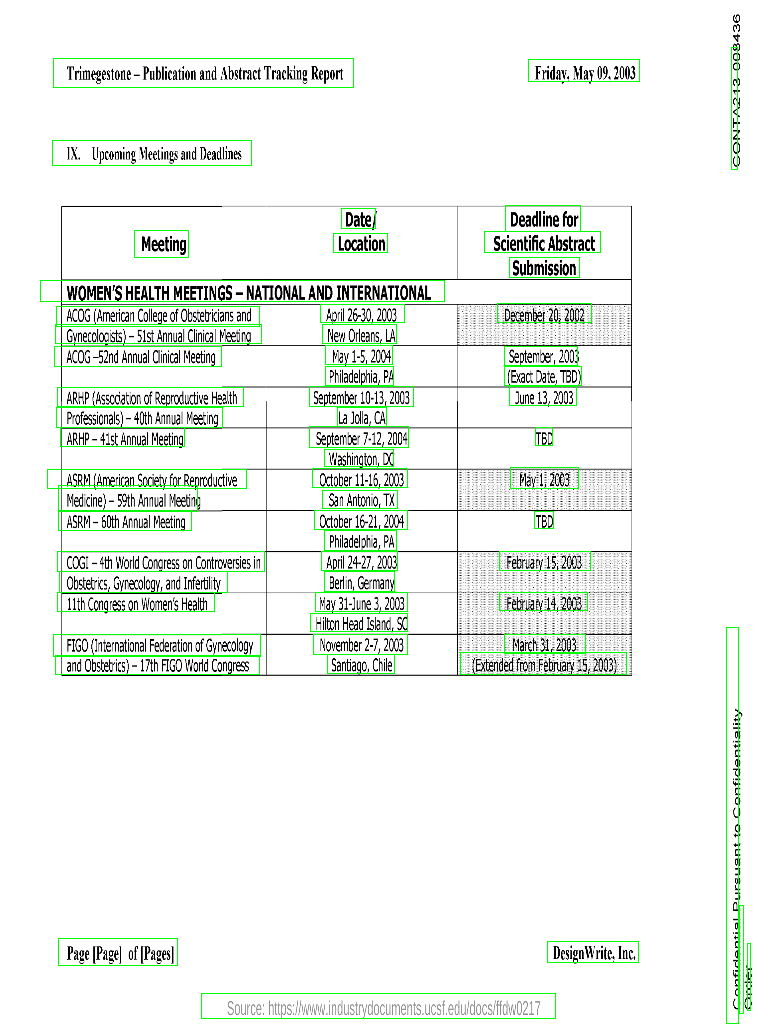

In [184]:
Image.fromarray(image_drawn.clip(0, 255).astype(np.uint8))